In [1]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/')

In [2]:
%matplotlib nbagg
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm
from built_functions import *

[INFO][corrections] Numba not available, reverting to Numpy


Set up the filters.  "numstds" is the number of standard deviations to take from the median.

Plot some diagnostics

In [3]:
def get_XAS(scan_name, DIR, DIR_json, numstds, minIzero, lin_filter, plotting_inital='no', plot_scans='yes'):
    #numstds = 2
    #minIzero = 0.015

    json_file = DIR_json + scan_name + "_scan_info.json"
    print (json_file)

    with open(json_file) as file:
        data = json.load(file)
    numFiles = len(data['scan_files'])

#     print ("Processing",numFiles,"files")

    DataFluo_pump_norm_total = np.empty(0)
    DataFluo_unpump_norm_total = np.empty(0)
    err_DataFluo_pump_total = np.empty(0)
    err_DataFluo_unpump_total = np.empty(0)

    IzeroFEL_pump_original_total = np.empty(0)
    IzeroFEL_pump_total = np.empty(0)
    IzeroFEL_unpump_original_total = np.empty(0)
    IzeroFEL_unpump_total = np.empty(0)

    DataFluo_pump_original_total = np.empty(0)
    DataFluo_pump_total = np.empty(0)
    DataFluo_unpump_original_total = np.empty(0)
    DataFluo_unpump_total = np.empty(0)
    
    
    condition_pump_mean = np.zeros(numFiles)
    condition_unpump_mean = np.zeros(numFiles)
#     err_pump = np.zeros(numFiles)
#     err_unpump = np.zeros(numfiles)

    Energy_eV = np.empty(0)
    iZero = np.empty(0)

    print('number of files')
    print(numFiles)
    
    for i in range(0,numFiles):
    #for i in range(0,1):
        filename = str(data['scan_files'][i][0])
        filename = DIR + os.path.basename(filename)
        exists = os.path.isfile(filename)
        if not exists:
            print("No such file")
        elif exists: #Do we need this 39?
#             print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
            (DataFluo_pump, DataFluo_unpump, IzeroFEL_pump, IzeroFEL_unpump, Energy, _, _, _) = \
                load_PumpProbe_events(filename, channel_energy)

            IzeroFEL_pump_original = IzeroFEL_pump.copy()
            IzeroFEL_unpump_original = IzeroFEL_unpump.copy()

            IzeroFEL_pump_original_total = np.append(IzeroFEL_pump_original_total, IzeroFEL_pump_original)
            IzeroFEL_unpump_original_total = np.append(IzeroFEL_unpump_original_total, IzeroFEL_unpump_original)

            DataFluo_pump_original_total = np.append(DataFluo_pump_original_total, DataFluo_pump)
            DataFluo_unpump_original_total = np.append(DataFluo_unpump_original_total, DataFluo_unpump)

            
            
            
            IzeroFEL_pump, IzeroFEL_unpump, DataFluo_pump, DataFluo_unpump, condFinalPump, condFinalUnPump\
                =filterData(IzeroFEL_pump, IzeroFEL_unpump, DataFluo_pump, DataFluo_unpump, numstds, minIzero, lin_filter)
            
            condition_pump_mean[i] = condFinalPump.mean()
            condition_unpump_mean[i] = condFinalUnPump.mean()
            
            
            IzeroFEL_pump_total = np.append(IzeroFEL_pump_total, IzeroFEL_pump)
            IzeroFEL_unpump_total = np.append(IzeroFEL_unpump_total, IzeroFEL_unpump)

            DataFluo_pump_total = np.append(DataFluo_pump_total, DataFluo_pump)
            DataFluo_unpump_total = np.append(DataFluo_unpump_total, DataFluo_unpump)

            DataFluo_pump_norm = DataFluo_pump/IzeroFEL_pump
            DataFluo_unpump_norm = DataFluo_unpump/IzeroFEL_unpump

            DataFluo_pump_norm_total = np.append(DataFluo_pump_norm_total, DataFluo_pump_norm.mean())
            DataFluo_unpump_norm_total = np.append(DataFluo_unpump_norm_total, DataFluo_unpump_norm.mean())
            err_DataFluo_pump_total = np.append(err_DataFluo_pump_total, DataFluo_pump_norm.std()/np.sqrt(DataFluo_pump_norm.size))
            err_DataFluo_unpump_total = np.append(err_DataFluo_unpump_total, DataFluo_unpump_norm.std()/np.sqrt(DataFluo_unpump_norm.size))
            
#             print(' data fluo size ' +str(DataFluo_pump_norm.size))
            
            
            Energy = [x for x in Energy if (np.abs(x) > 0)]            
            Energy_eV = np.append(Energy_eV, np.mean(Energy))
            
            
            iZero = [x for x in iZero if (np.abs(x) > 0)]
            iZero = np.append(iZero, np.mean(IzeroFEL_pump_total))
            
    Energy_eV = Energy_eV[0:]
    DataFluo_pump_norm_total = DataFluo_pump_norm_total[0:]
    DataFluo_unpump_norm_total = DataFluo_unpump_norm_total[0:]
    iZero =iZero[0:]    
    err_DataFluo_unpump_total = err_DataFluo_unpump_total[0:]
    err_DataFluo_pump_total = err_DataFluo_pump_total[0:]

    
    print('error Fluor pump shape ')
    print(err_DataFluo_pump_total.shape)
    
    
    if plotting_inital == 'yes':
    #     print("The original number of pumped and unpumped shots is:")
    #     print(IzeroFEL_pump_original_total.shape, IzeroFEL_unpump_original_total.shape)
    #     print("The filtered number of pumped and unpumped shots is:")
    #     print(IzeroFEL_pump_total.shape, IzeroFEL_unpump_total.shape)
        
    
        plt.figure()
        plt.plot(Energy_eV, condition_pump_mean, label = 'pumped condition')
        plt.plot(Energy_eV, condition_unpump_mean, label = 'Unpumped condition')
        plt.title(scan_name + ': condition lost')
        plt.ylabel('Average Condition Value')
        plt.xlabel('Mono Energy')
        plt.ylim([0,1.1])
        plt.legend()
        
        
        plt.figure()
        _, bins, _ = plt.hist(IzeroFEL_pump_original_total, 100, label = 'unfiltered')
        _ = plt.hist(IzeroFEL_pump_total, bins, rwidth = .5, label = 'filtered')
        plt.title(scan_name + ': Izero, pumped')
        plt.ylabel('Number of Shots')
        plt.xlabel('I0')
        plt.legend()

        
        plt.figure()
        plt.scatter(IzeroFEL_pump_original_total, DataFluo_pump_original_total)
        plt.scatter(IzeroFEL_pump_total, DataFluo_pump_total)
        plt.title(scan_name + ': Izero, pumped')
        plt.xlabel('I0')
        plt.ylabel('Absorption')
        
        plt.figure()
        _, bins, _ = plt.hist(IzeroFEL_unpump_original_total, 100, label = 'unfiltered')
        _ = plt.hist(IzeroFEL_unpump_total, bins, rwidth = .5, label = 'filtered')
        plt.title(scan_name + ': Izero, unpumped')
        plt.ylabel('Number of Shots')
        plt.xlabel('I0')
        plt.legend()
        
        
        plt.figure()
        plt.scatter(IzeroFEL_unpump_original_total, DataFluo_unpump_original_total)
        plt.scatter(IzeroFEL_unpump_total, DataFluo_unpump_total)
        plt.title(scan_name + ': Izero, pumped')
        plt.xlabel('I0')
        plt.ylabel('Absorption')
      
        plt.figure()
        plt.scatter(IzeroFEL_pump_original_total, DataFluo_pump_original_total)
        plt.scatter(IzeroFEL_pump_total, DataFluo_pump_total)
        plt.title('Izero, pumped')
        plt.xlabel('I0')
        plt.ylabel('Absorption')
        
    if plot_scans == 'yes':
        
        err_unpump_high = DataFluo_unpump_norm_total + err_DataFluo_unpump_total
        err_unpump_low = DataFluo_unpump_norm_total - err_DataFluo_unpump_total
        
        err_pump_high = DataFluo_pump_norm_total + err_DataFluo_pump_total
        err_pump_low = DataFluo_pump_norm_total - err_DataFluo_pump_total

        plt.figure()
        plt.plot(np.array(Energy_eV), DataFluo_unpump_norm_total,color = 'blue',label='UnPumped')
        plt.fill_between(Energy_eV, err_unpump_high, err_unpump_low, alpha = 0.3, color = 'blue')
        
        plt.plot(np.array(Energy_eV), DataFluo_pump_norm_total,color = 'orange',label='Pumped')
        plt.fill_between(Energy_eV, err_pump_high, err_pump_low, alpha = 0.3, color = 'orange')
        

#         plt.plot(np.array(Energy_eV), np.array(iZero)*100,label="I_zero_Arb")
        plt.xlabel('energy (eV)')
        plt.ylabel('absorption')
        plt.title('XAS_'+ scan_name)
        plt.legend()
        
    
    

    return iZero, Energy_eV, DataFluo_unpump_norm_total, DataFluo_pump_norm_total, err_DataFluo_pump_total, err_DataFluo_unpump_total
        

/sf/alvra/data/p17983/res/scan_info/RuDimerACN_monoscan_10ps_004_scan_info.json
number of files
34
error Fluor pump shape 
(34,)


<IPython.core.display.Javascript object>


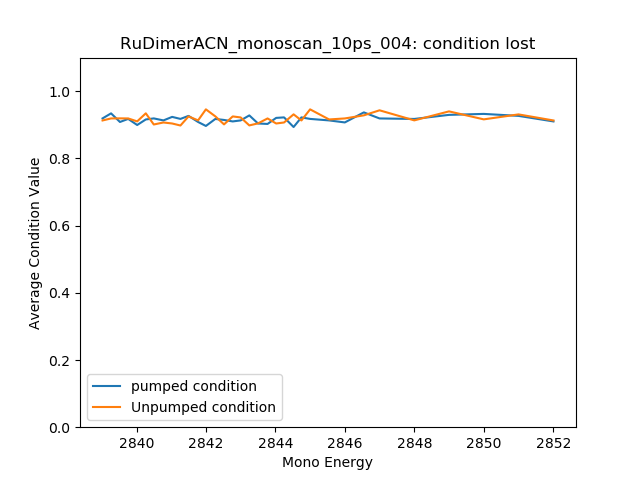

<IPython.core.display.Javascript object>


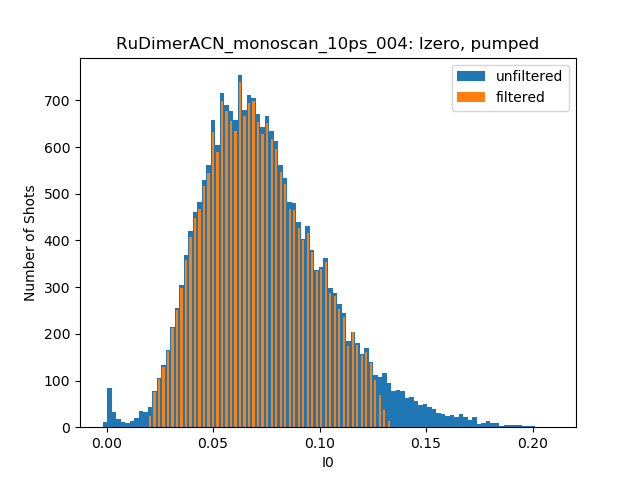

<IPython.core.display.Javascript object>


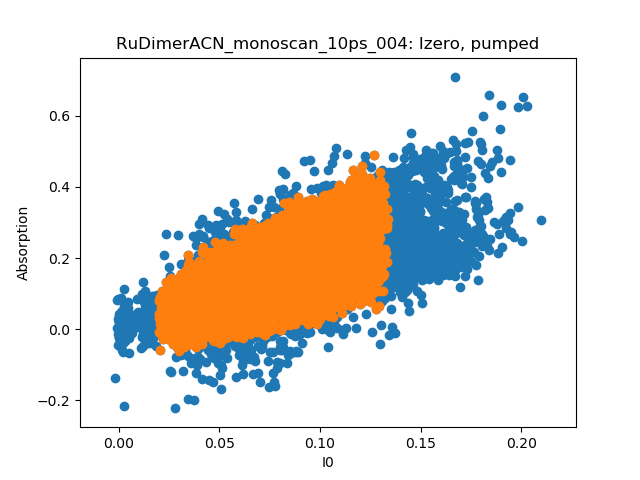

<IPython.core.display.Javascript object>


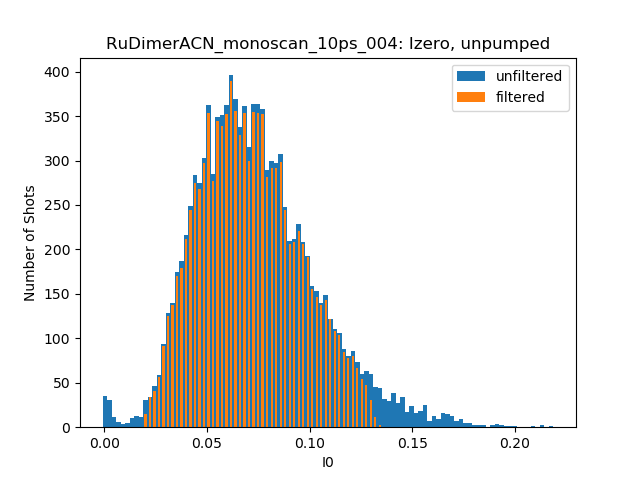

<IPython.core.display.Javascript object>


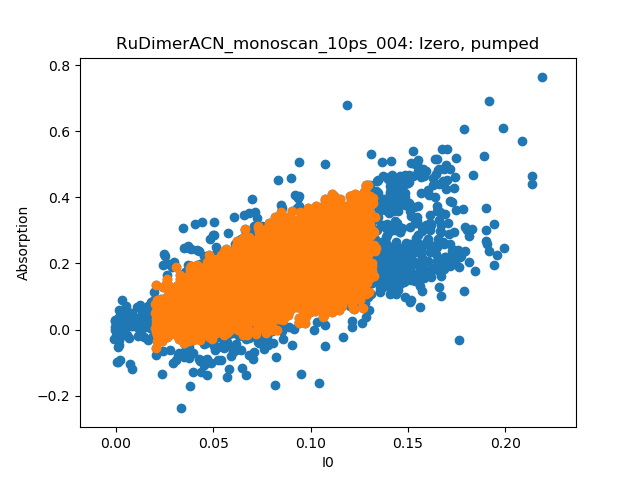

<IPython.core.display.Javascript object>


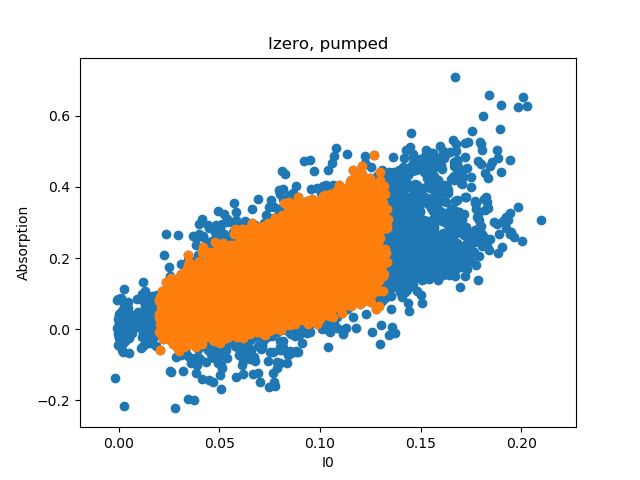

/sf/alvra/data/p17983/res/scan_info/RuDimerACN_monoscan_10ps_003_scan_info.json
number of files
55
error Fluor pump shape 
(55,)


<IPython.core.display.Javascript object>


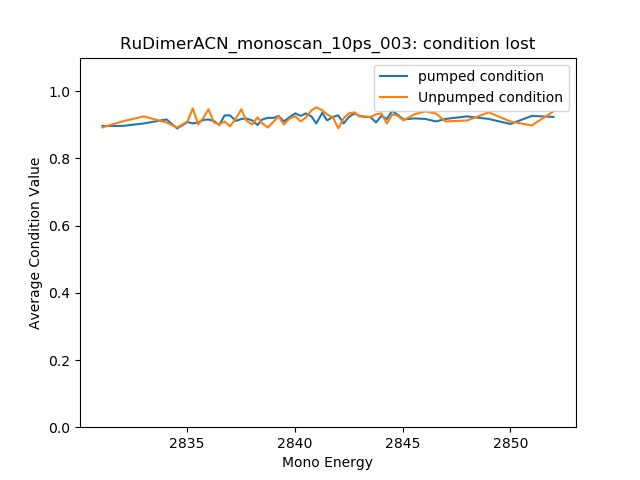

<IPython.core.display.Javascript object>


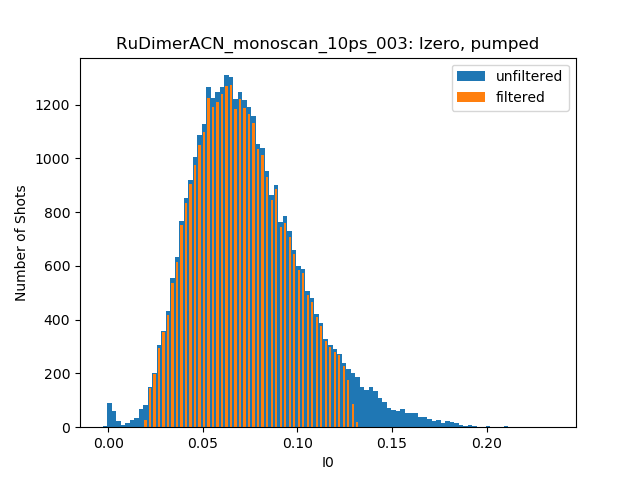

<IPython.core.display.Javascript object>


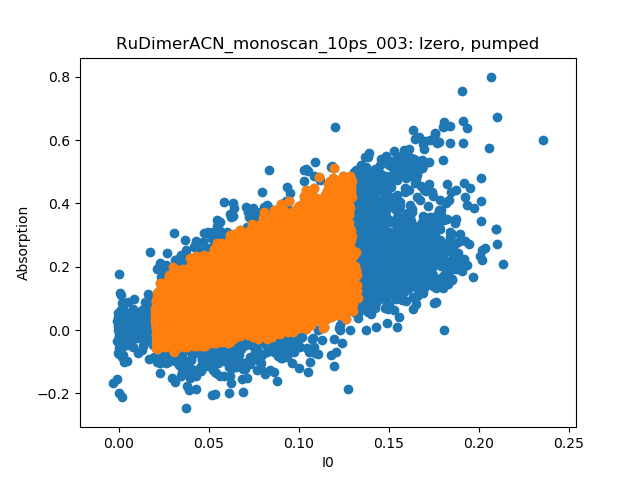

<IPython.core.display.Javascript object>


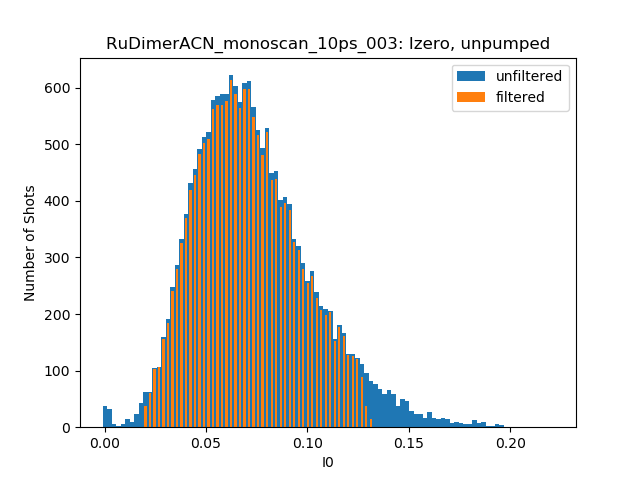

<IPython.core.display.Javascript object>


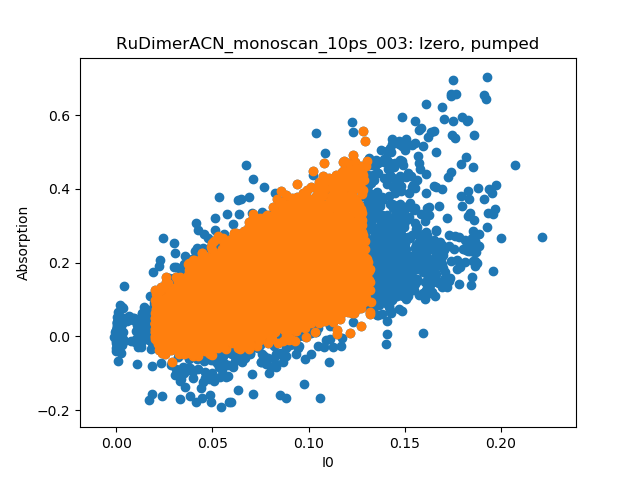

<IPython.core.display.Javascript object>


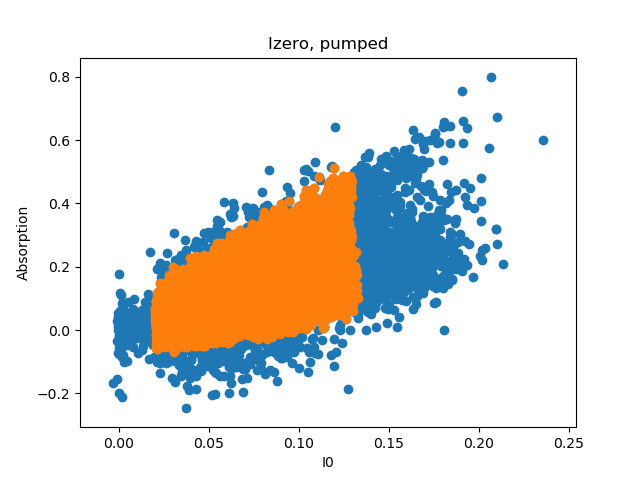

0
error 2 shape
(55,)
data total 2 shape
(55,)


In [4]:
ploton = True



#intial settings
# numstds = 3
# minIzero = 0.02
# lin_filter =0.1

numstds = 2
minIzero = 0.02
lin_filter = 0.1
plot_02 = 'yes'
plotting_inital ='yes' #shows the filtering of data
plot_scans = 'no' #shows each pump probe scan individually 


DIR_root = "/sf/alvra/data/p17983/raw/scan_data/"
DIR_json = "/sf/alvra/data/p17983/res/scan_info/"

# basename_01 = 'RuBpy3_monoscan_' # use for scan up to 22
basename_01 = 'RuDimerACN_monoscan_10ps_'
scanlist_01 = [4]
#scanlist_01 = [12]
strList_01 = list2Str(scanlist_01)


scan_name_01 = scanlist_01
n_01 = len(scanlist_01)



basename_02 = 'RuDimerACN_monoscan_10ps_'
scanlist_02 = [3]
strList_02 = list2Str(scanlist_02)

scan_name_02 = scanlist_02
n_02 = len(scanlist_02)



colorP = 'orange'
colorUP = "blue"


for i in range(0, n_01):
    if scanlist_01[i] < 10:
        scan_name = basename_01 + '00' + str(scanlist_01[i])
    else:
        scan_name = basename_01 + '0' + str(scanlist_01[i])
        
    DIR = DIR_root + scan_name + "/"

    iZero_, Energy_eV_, DataFluo_unpump_norm_total_, DataFluo_pump_norm_total_, err_DataFluo_pump_total_, err_DataFluo_unpump_total_\
    =get_XAS(scan_name, DIR, DIR_json, numstds, minIzero,lin_filter,plotting_inital,plot_scans)

    if i == 0:
        iZero_01 = iZero_/n_01
        Energy_eV_01 = Energy_eV_/n_01
        DataFluo_unpump_norm_total_01 = DataFluo_unpump_norm_total_/n_01
        DataFluo_pump_norm_total_01 = DataFluo_pump_norm_total_/n_01
        err_DataFluo_unpump_total_01 = err_DataFluo_unpump_total_
        err_DataFluo_pump_total_01 = err_DataFluo_pump_total_
    else:
        iZero_01 += iZero_/n_01
        Energy_eV_01 += Energy_eV_/n_01
        DataFluo_unpump_norm_total_01 += DataFluo_unpump_norm_total_/n_01
        DataFluo_pump_norm_total_01 += DataFluo_pump_norm_total_/n_01
        err_DataFluo_unpump_total_01 = err_adder(err_DataFluo_unpump_total_01, err_DataFluo_unpump_total_)
        err_DataFluo_pump_total_01 = err_adder(err_DataFluo_pump_total_01, err_DataFluo_pump_total_)
    
for i in range(0, n_02):
    if scanlist_02[i] < 10:
        scan_name = basename_02 + '00' + str(scanlist_02[i])
    else:
        scan_name = basename_02 + '0' + str(scanlist_02[i])
        
    DIR = DIR_root + scan_name + "/"

    iZero_, Energy_eV_, DataFluo_unpump_norm_total_, DataFluo_pump_norm_total_, err_DataFluo_pump_total_, err_DataFluo_unpump_total_\
    =get_XAS(scan_name, DIR, DIR_json, numstds, minIzero,lin_filter,plotting_inital,plot_scans)
    print(i)
    if i == 0:
        iZero_02 = iZero_/n_02
        Energy_eV_02 = Energy_eV_/n_02
        DataFluo_unpump_norm_total_02 = DataFluo_unpump_norm_total_/n_02
        DataFluo_pump_norm_total_02 = DataFluo_pump_norm_total_/n_02
        err_DataFluo_unpump_total_02 = err_DataFluo_unpump_total_
        err_DataFluo_pump_total_02 = err_DataFluo_pump_total_
        print('error 2 shape')
        print(err_DataFluo_pump_total_02.shape)

        print('data total 2 shape')
        print(DataFluo_pump_norm_total_02.shape)
    else:
        iZero_02 += iZero_/n_02
        Energy_eV_02 += Energy_eV_/n_02
        DataFluo_unpump_norm_total_02 += DataFluo_unpump_norm_total_/n_02
        DataFluo_pump_norm_total_02 += DataFluo_pump_norm_total_/n_02
        err_DataFluo_unpump_total_02 = err_adder(err_DataFluo_unpump_total_02, err_DataFluo_unpump_total_)
        err_DataFluo_pump_total_02 = err_adder(err_DataFluo_pump_total_02, err_DataFluo_pump_total_)

        



In [5]:
offset_min = 0.1
avg_p_bg_01 = DataFluo_pump_norm_total_01 - min(DataFluo_unpump_norm_total_01) + offset_min
avg_u_bg_01 = DataFluo_unpump_norm_total_01 - min(DataFluo_unpump_norm_total_01) + offset_min

avg_p_bg_02 = DataFluo_pump_norm_total_02 - min(DataFluo_unpump_norm_total_02) + offset_min
avg_u_bg_02 = DataFluo_unpump_norm_total_02 - min(DataFluo_unpump_norm_total_02) + offset_min


diff_01 = (avg_p_bg_01-avg_u_bg_01)/avg_u_bg_01

diff_02 = (avg_p_bg_02-avg_u_bg_02)/avg_u_bg_02




# aaa = [1, 2, 3, 4].T[0]
# bbb = aaa
# ccc = err_adder(aaa,bbb)
# print(ccc)




<IPython.core.display.Javascript object>


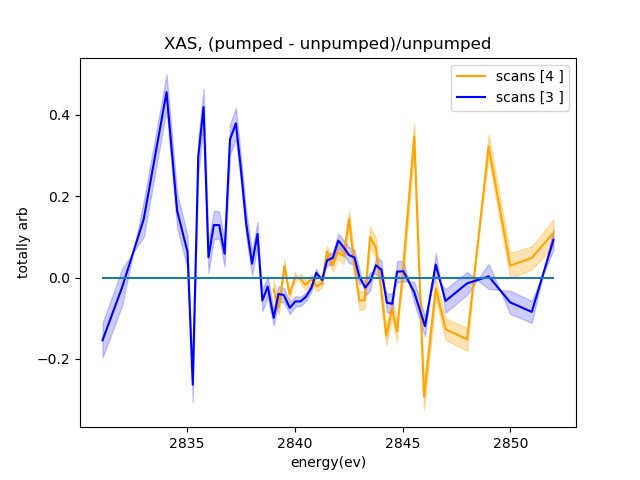

In [6]:



err_trans_01 = err_adder(err_DataFluo_unpump_total_01,err_DataFluo_pump_total_01)
err_trans_01 = err_adder(err_trans_01/diff_01,err_DataFluo_unpump_total_01/DataFluo_unpump_norm_total_01)*diff_01/DataFluo_unpump_norm_total_01


err_trans_02 = err_adder(err_DataFluo_unpump_total_02,err_DataFluo_pump_total_02)
err_trans_02 = err_adder(err_trans_02/diff_02,err_DataFluo_unpump_total_02/DataFluo_unpump_norm_total_02)*diff_02/DataFluo_unpump_norm_total_02


err_trans_high_01 = diff_01 + err_trans_01
err_trans_low_01 = diff_01 - err_trans_01

err_trans_high_02 = diff_02 + err_trans_02
err_trans_low_02 = diff_02 - err_trans_02


plt.figure()
plt.plot(np.array(Energy_eV_01), diff_01, color = colorP, label='scans '+strList_01)
plt.fill_between(np.array(Energy_eV_01),err_trans_low_01,err_trans_high_01, alpha = 0.3, color = colorP)

if plot_02 == 'yes':
    plt.plot(np.array(Energy_eV_02), diff_02, color = colorUP, label='scans '+strList_02)
    plt.fill_between(np.array(Energy_eV_02),err_trans_low_02,err_trans_high_02, alpha = 0.2, color = colorUP)

plt.legend()
plt.title('XAS, (pumped - unpumped)/unpumped')
plt.ylabel('totally arb')
plt.xlabel('energy(ev)')
if Energy_eV_01.shape[0]>Energy_eV_02.shape[0]:
    zeroLine = np.zeros(np.array(Energy_eV_01).shape)
    plt.plot(np.array(Energy_eV_01),zeroLine)
else:
    zeroLine = np.zeros(np.array(Energy_eV_02).shape)
    plt.plot(np.array(Energy_eV_02),zeroLine)
    

  


<IPython.core.display.Javascript object>


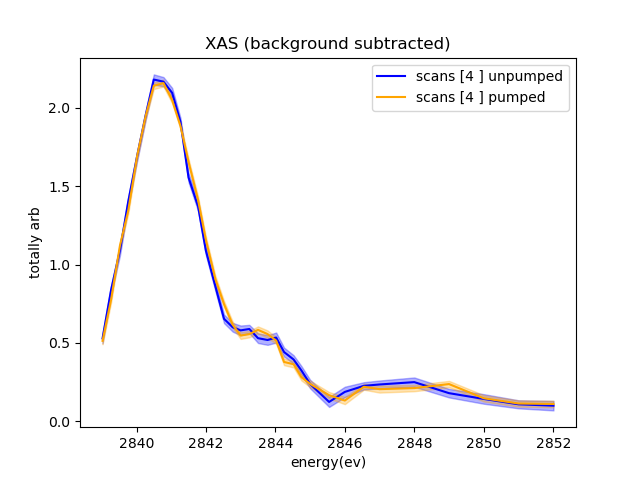

<IPython.core.display.Javascript object>


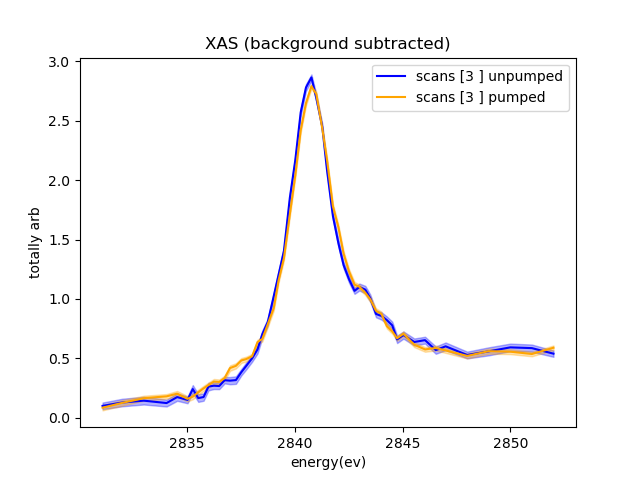

In [7]:
err_unpump_high_01 = avg_u_bg_01 + err_DataFluo_unpump_total_01
err_unpump_low_01= avg_u_bg_01 - err_DataFluo_unpump_total_01

err_pump_high_01 = avg_p_bg_01 + err_DataFluo_pump_total_01
err_pump_low_01 = avg_p_bg_01 - err_DataFluo_pump_total_01

err_unpump_high_02 = avg_u_bg_02 + err_DataFluo_unpump_total_02
err_unpump_low_02 = avg_u_bg_02 - err_DataFluo_unpump_total_02

err_pump_high_02 = avg_p_bg_02 + err_DataFluo_pump_total_02
err_pump_low_02 = avg_p_bg_02 - err_DataFluo_pump_total_02

    
plt.figure()
plt.plot(np.array(Energy_eV_01), avg_u_bg_01,color = colorUP , label='scans '+strList_01+' unpumped') 
plt.fill_between(np.array(Energy_eV_01), err_unpump_high_01, err_unpump_low_01, alpha = 0.3, color = colorUP)
plt.plot(np.array(Energy_eV_01), avg_p_bg_01,color = colorP, label='scans '+strList_01+' pumped')
plt.fill_between(np.array(Energy_eV_01), err_pump_high_01, err_pump_low_01, alpha = 0.3, color = colorP)
plt.legend()
plt.title('XAS (background subtracted)')
plt.ylabel('totally arb')
plt.xlabel('energy(ev)')


if plot_02 == 'yes':
    plt.figure()
    plt.plot(np.array(Energy_eV_02), avg_u_bg_02,color = colorUP , label='scans '+strList_02+' unpumped') 
    plt.fill_between(np.array(Energy_eV_02), err_unpump_high_02, err_unpump_low_02, alpha = 0.3, color = colorUP)
    plt.plot(np.array(Energy_eV_02), avg_p_bg_02,color = colorP, label='scans '+strList_02+' pumped')
    plt.fill_between(np.array(Energy_eV_02), err_pump_high_02, err_pump_low_02, alpha = 0.3, color = colorP)
    plt.legend()
    plt.title('XAS (background subtracted)')
    plt.ylabel('totally arb')
    plt.xlabel('energy(ev)')

